## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import re

### Data loading: "Евгений Онегин"


In [2]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
len(text)

141888

In [4]:
def get_sentences(text):
    sentences = re.split('\n+[ivxlcdm]+?\n+', text)
    del(sentences[0])
    return sentences

In [5]:
sentences = get_sentences(text)
print(len(sentences))

358


In [6]:
from collections import Counter
import plotly.express as px
counter = Counter(text)
symb, freq = zip(*counter.items())

px.bar(x=symb, y=freq, text_auto=True)

Очистим от латинских букв цифр и символов, т.к. сгенерировать из них осмысленное слово все равно не получится

Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
tokens = sorted(set(text))
tokens.append('<') # <SOS>
tokens.append('>') # <EOS>
tokens.append('_') # <PAD>
len(tokens)

86

In [8]:
sos = '<'
eos = '>'
pad = '_'

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [9]:
# dict <index>:<char>
token_to_id = {tok: idx for idx, tok in enumerate(tokens)}
print(token_to_id)
# dict <char>:<index>
id_to_token = {idx: tok for tok, idx in token_to_id.items()}
print(id_to_token.values())

assert list(id_to_token.keys()) == [idx for tok, idx in token_to_id.items()], 'ощибка в создании словарей'

{'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '5': 8, '7': 9, '8': 10, '9': 11, ':': 12, ';': 13, '?': 14, '[': 15, ']': 16, '^': 17, 'a': 18, 'b': 19, 'c': 20, 'd': 21, 'e': 22, 'f': 23, 'g': 24, 'h': 25, 'i': 26, 'k': 27, 'l': 28, 'm': 29, 'n': 30, 'o': 31, 'p': 32, 'q': 33, 'r': 34, 's': 35, 't': 36, 'u': 37, 'v': 38, 'w': 39, 'x': 40, 'y': 41, 'z': 42, '«': 43, '»': 44, 'а': 45, 'б': 46, 'в': 47, 'г': 48, 'д': 49, 'е': 50, 'ж': 51, 'з': 52, 'и': 53, 'й': 54, 'к': 55, 'л': 56, 'м': 57, 'н': 58, 'о': 59, 'п': 60, 'р': 61, 'с': 62, 'т': 63, 'у': 64, 'ф': 65, 'х': 66, 'ц': 67, 'ч': 68, 'ш': 69, 'щ': 70, 'ъ': 71, 'ы': 72, 'ь': 73, 'э': 74, 'ю': 75, 'я': 76, 'ё': 77, '–': 78, '—': 79, '’': 80, '…': 81, '€': 82, '<': 83, '>': 84, '_': 85}
dict_values(['\n', ' ', '!', '(', ')', ',', '-', '.', '5', '7', '8', '9', ':', ';', '?', '[', ']', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', 

In [10]:
print(token_to_id['м'])
print(id_to_token[51])

57
ж


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def data_to_tensor(sentence: list[str], max_len: int):
    sos = '<'
    eos = '>'
    pad = '_'
    sentence_tensor = torch.zeros(len(sentence), max_len, dtype=torch.long, device=device) + token_to_id[pad]
    sentence_tensor[:, 0] = token_to_id[sos]

    for i, string in enumerate(sentence):
        token_tensor = torch.tensor(list(map(token_to_id.get, string)), dtype=torch.long, device=device)
        sentence_tensor[i, 1: len(token_tensor) + 1] = token_tensor
        sentence_tensor[i, len(token_tensor) + 1] = token_to_id[eos]

    return sentence_tensor

In [13]:
print(sentences[0])
data_to_tensor(sentences, 2500)[0]

«мой дядя самых честных правил,
когда не в шутку занемог,
он уважать себя заставил
и лучше выдумать не мог.
его пример другим наука;
но, боже мой, какая скука
с больным сидеть и день и ночь,
не отходя ни шагу прочь!
какое низкое коварство
полуживого забавлять,
ему подушки поправлять,
печально подносить лекарство,
вздыхать и думать про себя:
когда же черт возьмет тебя!»


tensor([83, 43, 57,  ..., 85, 85, 85], device='cuda:0')

In [14]:
len(sentences)

358

In [15]:
class RNN(nn.Module):
    def __init__(self, num_tok, emb_size, hidden_size, n_layers=1):
        super().__init__()
        torch.manual_seed(42)
        
        self.num_tok = num_tok
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.emb = nn.Embedding(num_tok, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_tok)

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True, device=device)
    
    def forward(self, input_text, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(len(input_text))


        out_emb = self.emb(input_text)
        out_rnn, hidden = self.rnn(out_emb, hidden)
        out_x = self.linear(out_rnn)
        return out_x, hidden

In [16]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output


def get_batch(data, batch_size, shuffle=False):
    if shuffle:
        indices = np.random.permutation(len(data))
    for start_idx in tqdm(range(0, len(data) - batch_size + 1, batch_size)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield data[excerpt]

In [17]:
def train_epoch(model,
                criterion,
                optimizer,
                data_train: np.ndarray,
                batch_size: int = 64):
    loss_log = []

    model.train()
    for data_batch in get_batch(data_train, batch_size=batch_size, shuffle=True):
        # Преобразуем data_batch в торч тензор с помощью функции data_to_tensor
        data_batch = data_to_tensor(data_batch, max_len).to(device) 

        # Получаем предсказания модели
        output, _ = model(data_batch)

        # Вычисляем функцию потерь
        loss = criterion(output[:, :-1, :].transpose(1, 2), data_batch[:, 1:])
        loss_log.append(loss.item())

        # Обнуляем градиенты, используя метод zero_grad() в оптимизаторе
        optimizer.zero_grad()

        # Производим обратный проход от функции потерь
        loss.backward()

        # Производим шаг оптимизации
        optimizer.step()
    return loss_log
        
        

In [18]:
def test_model(model,
               criterion,
               data_test: np.ndarray,
               batch_size: int = 64):
    loss_log = []
    model.eval()
    for data_batch in get_batch(data_test, batch_size=batch_size, shuffle=True):
        # Преобразуем data_batch в торч тензор с помощью функции data_to_tensor
        data_batch = data_to_tensor(data_batch, max_len).to(device) 

        # Получаем предсказания модели
        output, _ = model(data_batch)

        # Вычисляем функцию потерь, используя criterion
        loss = criterion(output[:, :-1, :].transpose(1, 2), data_batch[:, 1:])
        loss_log.append(loss.item())
    return loss_log


def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)

    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='test', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [19]:
def train(model,
          criterion,
          optimizer,
          data_train: np.ndarray,
          data_test: np.ndarray,
          n_epochs: int = 100,
          batch_size: int = 64,
          plot: bool = True):
    train_log = []
    val_log = []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        # Вызываем функции обучения модели на одной эпохи и тестирования
        train_loss = train_epoch(model, criterion, optimizer, data_train, batch_size)
        val_loss = test_model(model, criterion, data_test, batch_size)

        train_log.extend(train_loss)

        steps = len(data_train) / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))

        clear_output()
        if plot:
            plot_history(train_log, val_log)
        print("Epoch {} loss: {:.2}".format(epoch + 1, val_log[-1][1]))

    print("Best loss: {:.2}".format(sorted(val_log, key=lambda x: x[1])[0][1]))

In [20]:
from sklearn.model_selection import train_test_split
max_len=2500

text_train, text_test = train_test_split(np.array(sentences), test_size=0.2)


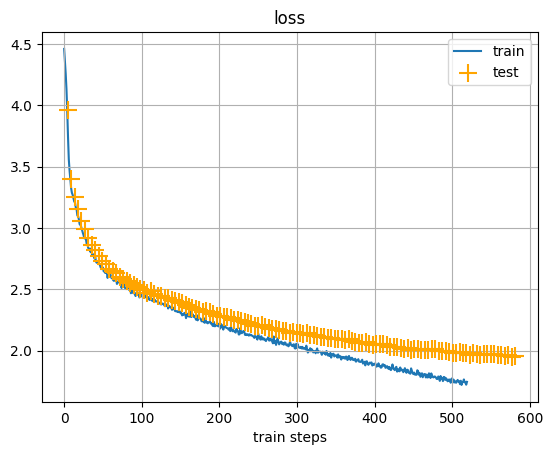

Epoch 130 loss: 2.0
Best loss: 1.9


In [21]:
model = RNN(num_tok=len(token_to_id), emb_size=150, hidden_size=500, n_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=token_to_id[pad])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

train(model, criterion, optimizer, text_train, text_test, n_epochs=130, batch_size=64)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [22]:
def generate_sentence_RNN(model, prime: str = '<', max_length: int = 20, temperature: float = 1.):
    prime_tensor = torch.tensor([list(map(token_to_id.get, prime))], dtype=torch.long, device=device)

    model.eval()
    for _ in range(max_length):
        output, _ = model(prime_tensor)

        next_prob = F.softmax(output[0, -1, :] / temperature, dim=0).detach().cpu().numpy()
        next_id = np.random.choice(len(token_to_id), p=next_prob)

        next_token = torch.tensor([[next_id]], dtype=torch.long, device=device)
        prime_tensor = torch.cat([prime_tensor, next_token], dim=1)

        if next_id == token_to_id[eos]:
            break
    return ''.join([id_to_token[ti] for ti in prime_tensor.cpu().numpy()[0]])

In [23]:
for temperature in [0.1, 0.4, 0.5, 0.6, 1, 1.5, 2, 5]:
    print(f'temperature = {temperature}')
    for _ in range(8):
        print('\t', generate_sentence_RNN(model, prime='<', temperature=temperature))
    print('\n')
    

temperature = 0.1
	 <в сердце в сердце го
	 <но в ней не полно с 
	 <но в ней не после та
	 <но в ней не полно с 
	 <но в сердце в сердце
	 <он при своей долго с
	 <но в ней не после те
	 <и всё девиц он он пр


temperature = 0.4
	 <она страсти моей соб
	 <татьяна с ней запет 
	 <но в посторой запет 
	 <он приходит она друз
	 <татьяна полно, как н
	 <и всё в нем он сердц
	 <он может был в тепер
	 <и все девели в после


temperature = 0.5
	 <старит старини всё ж
	 <он в страстей на сто
	 <но был был с нам отн
	 <моей нестолых ленски
	 <уж не вошет оставить
	 <до печальные полно в
	 <он от не знаю меня п
	 <он сердце мертвой де


temperature = 0.6
	 <и тайных приновленны
	 <он угрядной береспет
	 <но и татьяна спесных
	 <он при верца твердос
	 <за ней невознаком ст
	 <не можел я нем не хо
	 <как не странти страс
	 <и ничего полонит сем


temperature = 1
	 <он без рожит ленский
	 <он попленнил готов с
	 <с ядинит однах оне в
	 <котьчут виду моец ут
	 <«не встреженственниц
	 <при дуком нез

При температуре 0.1 текст каждой строчкой выдает самое вероятное слово на следуующем шаге, на температурах близким к 1 - неразборчивый текст. оптимум получился на температурах 0.3-0.5.  С увеличением температуры текст меньше становится похожим на исходный текст и все больше начинает придумывать новые слова

In [24]:
def generate_sample_RNN(char_rnn,
                    seed_phrase='Онегин',
                    max_length=2500,
                    temperature=1.0):
    
    x_sequence = [token_to_id[t] for t in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.long, device=device)   

    hid_state = char_rnn.init_hidden(batch_size=1)              

    for t in range(x_sequence.size(1) - 1):
        _, hid_state = char_rnn(x_sequence[:, t:t+1], hid_state)  

    for _ in range(max_length - len(seed_phrase)):
        logits, hid_state = char_rnn(x_sequence[:, -1:], hid_state)  
        logits = logits[:, -1, :] / temperature                    

        p_next = torch.softmax(logits, dim=-1).squeeze().cpu().detach().numpy()

        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix_t = torch.tensor([[next_ix]], dtype=torch.long,device=device)     

        x_sequence = torch.cat([x_sequence, next_ix_t], dim=1)

        if tokens[next_ix] == '>':       # остановка по EOS
            break

    return ''.join(tokens[ix] for ix in x_sequence.squeeze().tolist())


In [25]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
result = generate_sample_RNN(model, seed_phrase='<цветы, любовь, деревня, праздность, поля! я предан вам душой\n', max_length= 2500, temperature=0.2)
ind = result.find('>')
print(result[0: ind+1])

<цветы, любовь, деревня, праздность, поля! я предан вам душой
она в том с нем он перед ней
не полет и страстей не стари,
и весно в сердце грустной старины
и все дева порой старин,
и страсти молодой старины,
и в старой старины простила
и всё деверный и посторой
и старине привет порой
в сердце не полет и том,
и в сердце в посторой страна,
в том с ней не света не света
пред ним сердце горов она.>


In [26]:
import torch, torch.backends.cudnn as cudnn
del model                   
del optimizer, criterion    
torch.cuda.empty_cache()
torch.cuda.ipc_collect() 
torch.use_deterministic_algorithms(False) 
cudnn.deterministic = False
cudnn.benchmark     = True 

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [27]:
class LSTM(nn.Module):
    def __init__(self, num_tok, emb_size, hidden_size, n_layers=1):
        super().__init__()
        torch.manual_seed(42)

        self.num_tok = num_tok
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        # self.drop_share = drop_share

        self.emb = nn.Embedding(num_tok, emb_size)
        self.drop = nn.Dropout(0.5) 
        self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, batch_first=True, dropout=0.5)
        # self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_tok)
        

    def init_hidden(self, batch_size):
        # h0 и c0: (n_layers, batch, hidden_size)
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size,
                         device=self.emb.weight.device)
        c0 = torch.zeros_like(h0)
        return (h0, c0)
    
    def forward(self, input_text, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(len(input_text))


        out_emb = self.drop(self.emb(input_text)) 
        out_rnn, hidden = self.rnn(out_emb, hidden)
        out_x = self.linear(out_rnn)
        return out_x, hidden

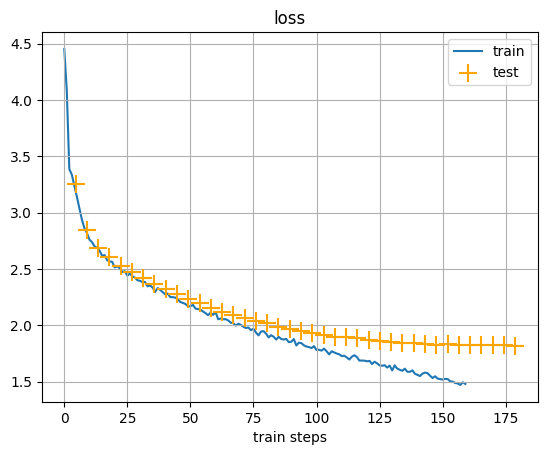

Epoch 40 loss: 1.8
Best loss: 1.8


In [28]:
lstm = LSTM(num_tok=len(token_to_id), emb_size=300, hidden_size=900, n_layers=1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=token_to_id[pad])
optimizer = torch.optim.Adam(lstm.parameters(), lr=2.3e-3)

train(lstm, criterion, optimizer, text_train, text_test, n_epochs=40, batch_size=64)

Модель LSTM замедно охотнее сходится к ошибке loss=1.9 чем ванильная RNN(которая получает loss=1.9 только когда зарандомит) и требует меньше эпох для схождения. Но несколько часов проб и ошибок и мне удалось подобрать параметры и обучить LSTM с меньшей ошибкой чем RNN (loss=1.8)

Plot the loss function of the number of epochs. Does the final loss become better?

In [29]:
def generate_sample_LSTM(char_rnn,
                    seed_phrase='Онегин',
                    max_length=2500,
                    temperature=1.0):
    

    x_sequence = [token_to_id[t] for t in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.long, device=device)  

    hid_state = char_rnn.init_hidden(batch_size=1)             

    for t in range(x_sequence.size(1) - 1):
        _, hid_state = char_rnn(x_sequence[:, t:t+1], hid_state)  

    
    for _ in range(max_length - len(seed_phrase)):
        logits, hid_state = char_rnn(x_sequence[:, -1:], hid_state) 
        logits = logits[:, -1, :] / temperature                    

        p_next = torch.softmax(logits, dim=-1).squeeze().cpu().detach().numpy()

        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix_t = torch.tensor([[next_ix]], dtype=torch.long,device=device)      

        x_sequence = torch.cat([x_sequence, next_ix_t], dim=1)

        if tokens[next_ix] == '>':       # остановка по EOS
            break

   
    return ''.join(tokens[ix] for ix in x_sequence.squeeze().tolist())


In [30]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
result = generate_sample_LSTM(lstm, seed_phrase='<цветы, любовь, деревня, праздность, поля! я предан вам душой\n', max_length= 2500, temperature=0.2)
ind = result.find('>')
print(result[0: ind+1])

<цветы, любовь, деревня, праздность, поля! я предан вам душой
он просто в ней на воле последной
в сей не свои молчаливой,
не встретить в таня полный друг,
под ним онегин с ним она
и в самом деревню в санях
простой страсти молодой,
в семьем от него не видит,
и все долго с ним она в своей.>


In [31]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [32]:
def generate_sentence_LSTM(model,
                      prime: str = '<',
                      max_length: int = 20,
                      temperature: float = 1.0):
    
    model.eval()

    # подготовим вход 
    prime_idx = [token_to_id[c] for c in prime]
    x = torch.tensor([prime_idx], dtype=torch.long, device=device)       

    # инициализируем скрытое состояние (hx, cx)
    h = torch.zeros(model.n_layers, 1, model.hidden_size, device=device)
    c = torch.zeros_like(h)

    # 'скармливаем' все символы seed‑фразы, кроме последнего 
    if x.size(1) > 1:
        _, (h, c) = model(x[:, :-1], (h, c))

   
    for _ in range(max_length - len(prime)):
        logits, (h, c) = model(x[:, -1:], (h, c))     
        logits = logits[:, -1] / temperature          

        probs = torch.softmax(logits, dim=-1).squeeze().detach().cpu().numpy()
        next_id = np.random.choice(len(token_to_id), p=probs)

      
        x = torch.cat([x, torch.tensor([[next_id]], device=device)], dim=1)

        if next_id == token_to_id[eos]:
            break

    return ''.join(id_to_token[i] for i in x.squeeze().tolist())


In [37]:
for temperature in [0.1, 0.2, 0.5, 1, 2]:
    print(f'temperature = {temperature}')
    for _ in range(3):
        print('\t', generate_sentence_LSTM(lstm, prime='<', temperature=temperature))
    print('\n')
    

temperature = 0.1
	 <но в ней на столом 
	 <но вот уж не привыч
	 <он мне приятно в са


temperature = 0.2
	 <но в самом деленный
	 <но в ней сердце в н
	 <привычка в самом ду


temperature = 0.5
	 <он проздный и друг 
	 <и полны, был так же
	 <но поседе странный 


temperature = 1
	 <но яжокая чай бега,
	 <его мышля мых и наш
	 <и слезы и брегникец


temperature = 2
	 <пушек, хлюдвят, кто
	 <«свокто не знатов л
	 <zи ще жизнь (ха;p; 




### Saving and loading models

In [34]:
with open(f"saved_model.pth", "wb") as fp:
                 torch.save(lstm.state_dict(), fp)

In [35]:
with open("saved_model.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    lstm.load_state_dict(best_state_dict)

In [36]:

print('\t', generate_sentence_LSTM(lstm, prime='<летел, устал, спал', max_length= 500, temperature=0.4))

	 <летел, устал, спала разлуков
и предостного писать она.>


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)